In [73]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import adjust_spines

# sbi
import sbi.utils as utils
from sbi.neural_nets.net_builders import build_maf
from sbi.inference import NPE

# import saver utilities
import pickle

# to check how long things take
import time

## Loading observed experimental data

Scala:

In [2]:
# All 25 degree Celcius mouse motor cortex (M1) electrophysiological data, preprocessed
M1_25degree = pickle.load(open('pickles/M1_features.pickle', 'rb'))
ephys_features = M1_25degree['X_o'].columns
Xo = M1_25degree['X_o'].copy()

In [3]:
prop = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep = '\t')
prop = prop.rename(columns = {'Targeted layer': 'Layer'})
prop = prop[['Cell', 'Layer', 'Cre', 'RNA type']]
prop = prop.set_index('Cell')
prop=prop.reindex(Xo.index)
no_low_qual=np.array(list(map(str,prop['RNA type'].values)))!='nan'
prop=prop.loc[no_low_qual,:]
Xo = Xo.loc[no_low_qual,:]
celltypes=prop['RNA type']

Gouwens:

In [74]:
# All 25 degree Celcius mouse motor cortex (M1) electrophysiological data, preprocessed
V1_25degree = pickle.load(open('pickles/V1_features.pickle', 'rb'))
ephys_features = V1_25degree['X_o'].columns
Xo_v1 = V1_25degree['X_o'].copy()

In [75]:
Xo_v1['Current'].min()

30.0

In [76]:
Xo_v1['Current'].max()

720.0

## The uniform prior

Scala:

In [4]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min),
    high=torch.as_tensor(prior_max)
)

Gouwens:

In [ ]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,    870]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min),
    high=torch.as_tensor(prior_max)
)

## Training schedules

In [78]:
feature_list=range(23) # we consider all ephys features
N_closest=1000 # number of closest prior simulations per cell we are going to keep

Choose data set:

In [79]:
ds = 'V1' # M1
D = Xo.copy() if ds=='M1' else Xo_v1.copy()

In [80]:
all_stats=[]
all_theta=[]

theta=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['theta']
stats=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['stats']

# Do not include non-spiking simulations
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping,:]
print('Final # non-nan simulations: ', stats.shape[0])

# Mean and standard deviation to Z-score with
s_mean=stats.mean(axis=0)
s_std=stats.std(axis=0)

t = time.time()

for i, cell_name in enumerate(D.index): # iterate over every cell in our experimental dataset
    print('.',end='')

    # Pick N_closest simulations to the experimental observation's summary statistics
    # Distance is the Euclidean Z-scored distance
    xo=D.loc[cell_name,:].values[feature_list]

    ind=np.argsort(
        np.sum(
            np.square(
                (stats-s_mean)/s_std-(xo-s_mean)/s_std
            ), axis=1
        )
    )[0:N_closest]
    
    stats_=stats[ind,:]
    theta_=theta[keeping,:][ind,:]
    
    all_stats.append(stats_)
    all_theta.append(theta_)
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('\nTime: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Final # non-nan simulations:  194660
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [90]:
theta_tr = np.concatenate(all_theta,axis=0) 
stats_tr = np.concatenate(all_stats,axis=0)

if ds=='M1':
    np.savez('./save_sims/best_{}_Euclidean_sims.npz'.format(N_closest),
        theta=theta_tr,
        stats=stats_tr
        )
else:
    np.savez('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds),
        theta=theta_tr,
        stats=stats_tr
        )

In [91]:
training_schedules={'0':{}, '1':{}, '2a':{}, '2b':{}, '2c':{}, '2d':{}, '2e':{}, '3':{}, '4':{}}

#### Training schedule 0: a batch of spiking non-inf/non-nan simulations from the prior.

In [ ]:
theta=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['theta']
stats=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['stats']

## Do not include non-spiking simulations
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1))) # delete Nan simulations
theta_tr = theta[keeping,:][::43,:]
stats_tr = stats[keeping,:][::43,:]

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['0'].update({'theta':theta_tr, 'stats':stats_tr})

tcmalloc: large alloc 1380007936 bytes == 0xb4faa000 @ 


(# sims, # model parameters):  (166409, 13)
(# sims, # ephys features):  (166409, 23)


**ToDo**: do ::43 again after including more simulations

In [97]:
theta=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['theta']
stats=np.load('./save_sims/{}_chunks/full_batch.npz'.format(ds))['stats']

## Do not include non-spiking simulations
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1))) # delete Nan simulations
theta_tr = theta[keeping,:][::4,:]
stats_tr = stats[keeping,:][::4,:]

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)


training_schedules['0'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (48665, 14)
(# sims, # ephys features):  (48665, 23)


In [93]:
limits={'AP threshold':[-120,75], 'AP amplitude':[0,200], 'AP width':[0,5], 'AHP':[-80,50], \
        '3rd AP threshold':[-100,100], '3rd AP amplitude':[0,200], '3rd AP width':[0,5], '3rd AHP':[-60,30], \
        'AP count':[0,400], 'AP count 1st 8th': [0,135], 'AP count 1st quarter': [0,180], \
        'AP count 1st half':[0,200], 'AP count 2nd half':[0,200], 'AP amp adapt':[-1.5,1.5], \
        'AP average amp adapt':[-0.1,1.1], 'AP CV':[-7.5,0], \
        'ISI adapt':[-3,3], 'ISI CV':[-8,2.5], 'latency':[-2,6.5], r'rest $V_{m}$ mean':[-120,100], \
        r'$V_{m}$ mean':[-110,50], r'$V_{m}$ std':[0,2000], r'$V_{m}$ skewness':[-2,12], \
        'Vi':[-150,-40], '1-comp area':[0,4000]}

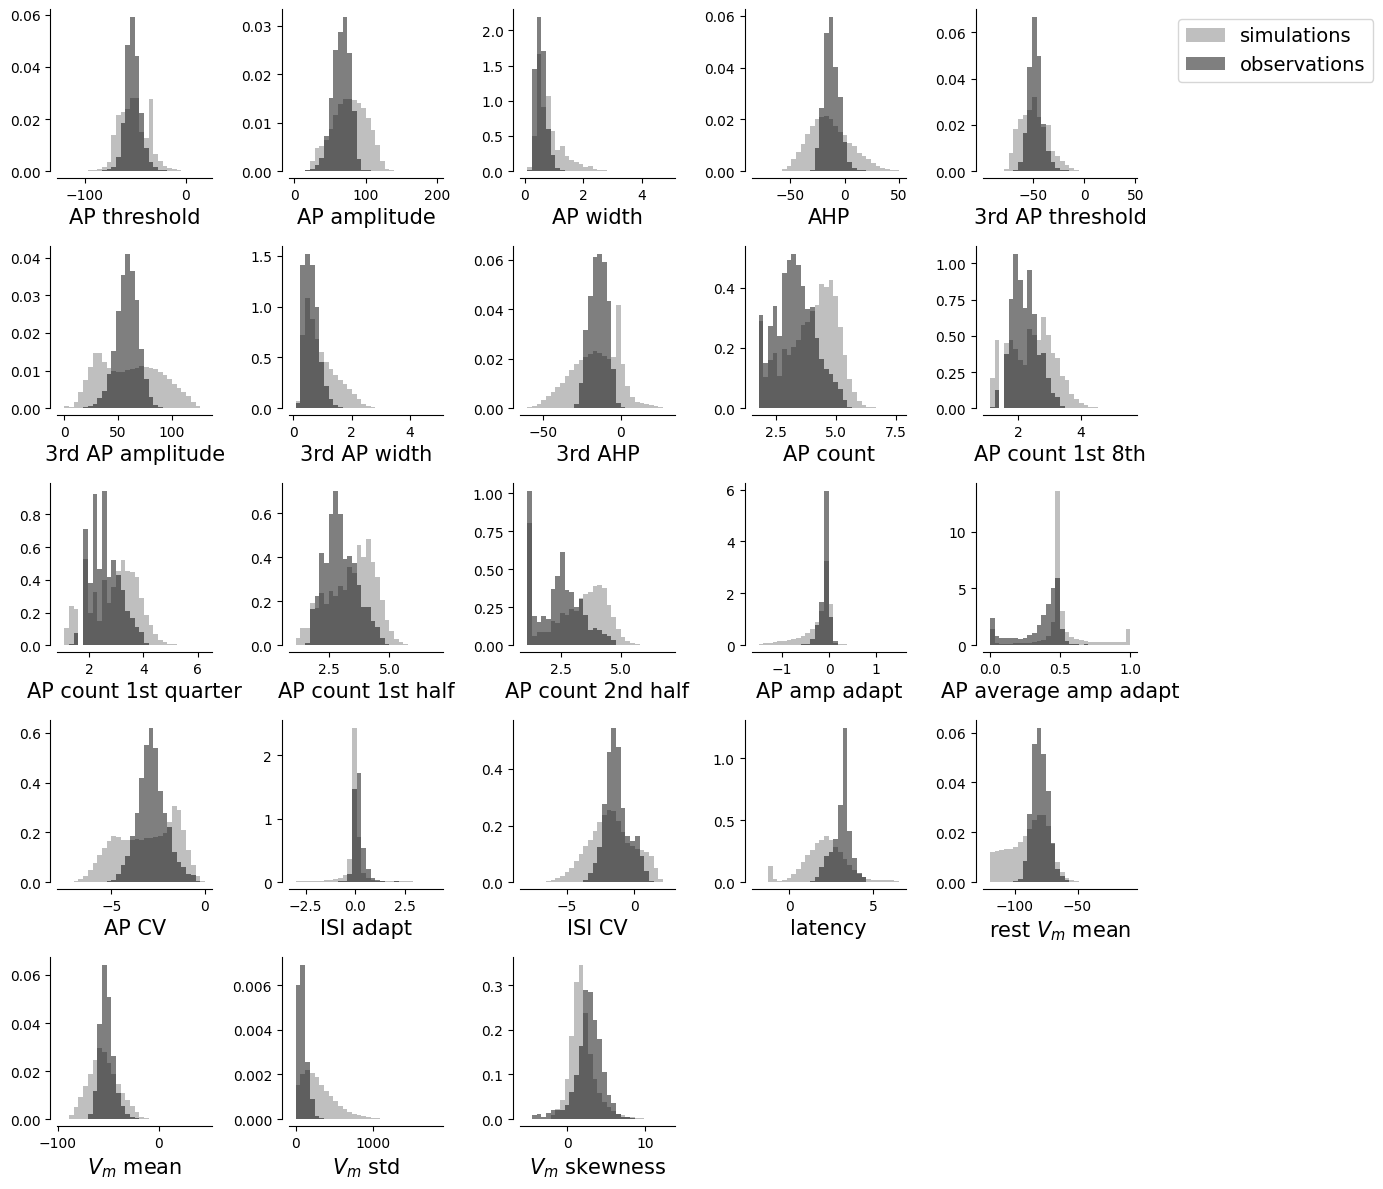

In [94]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        
        adjust_spines(ax,['left', 'bottom'])

for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

#### Training schedule 1: *unique* best Euclidean prior simulations.

Some of our experimental observations have very simimlar observed ephys features or summary statistics, so they can share prior simulations in their batch of N_closest best Euclidean prior simulations. After concatenating all batches of prior simulations (every batch of prior simulations belongs to one experimental observation), there exist duplicates of prior simulations. We therefore keep only unique ones as to avoid duplicate training examples.

In [98]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['1'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


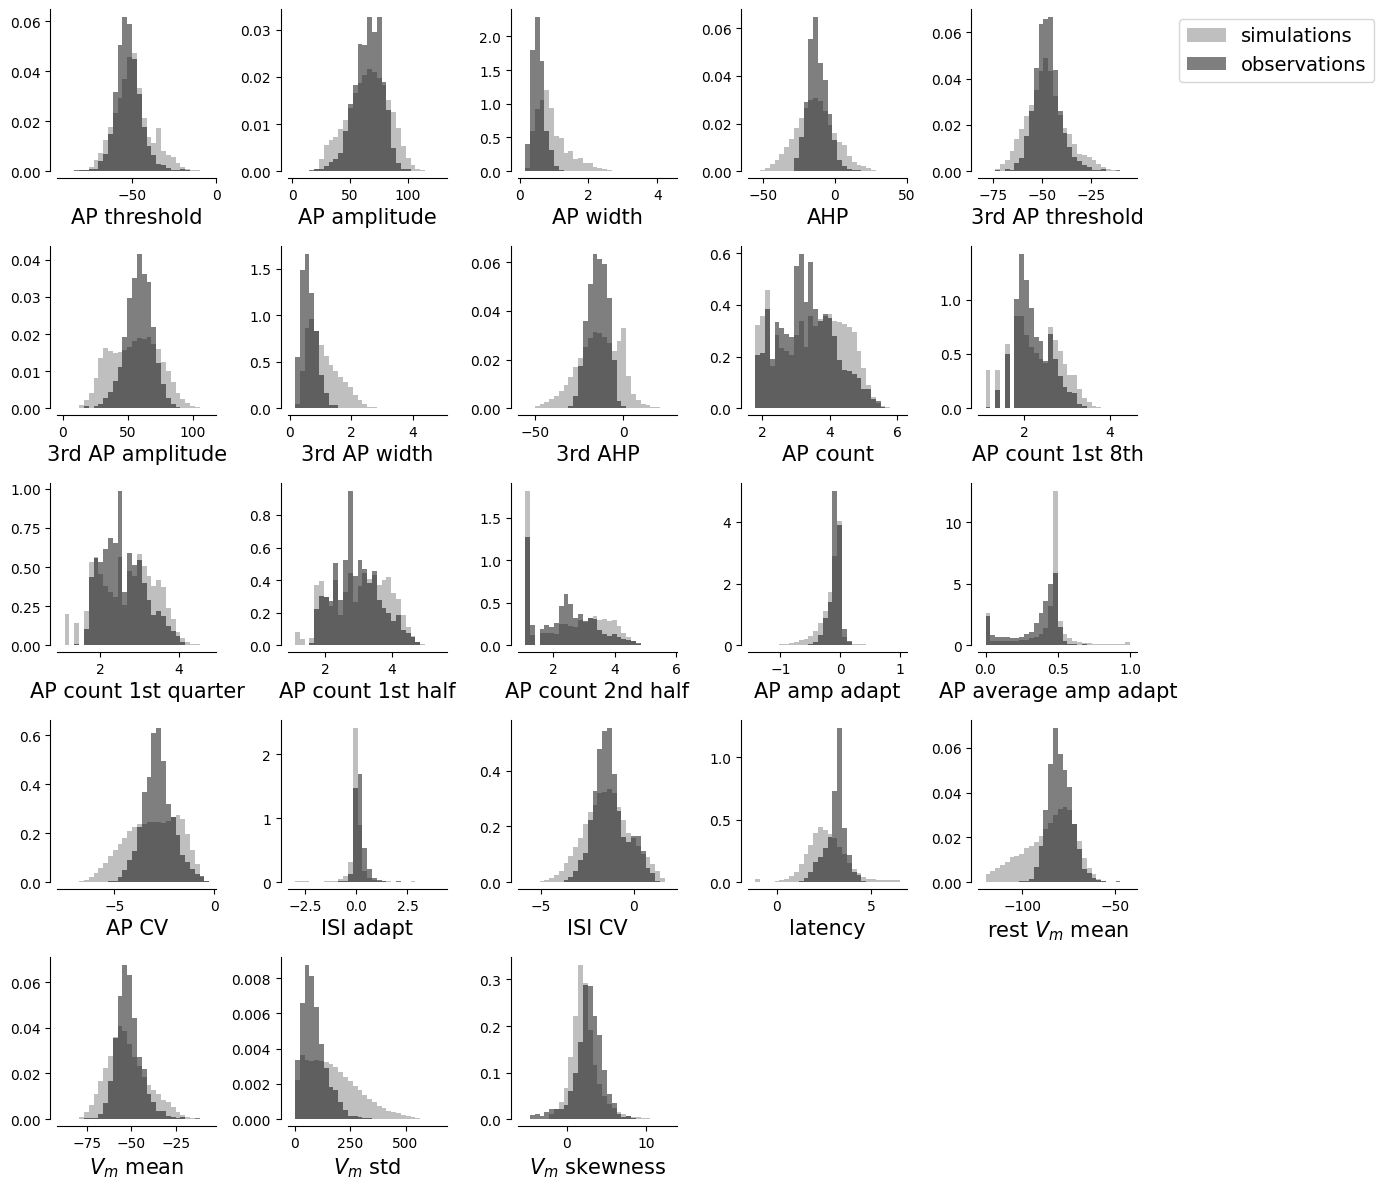

In [99]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        adjust_spines(ax,['bottom', 'left'])
for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

#### Training schedule 2a: noise with 0.001 amplitude added to ephys features of unique best Euclidean prior simulations

In [100]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=0.001 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
stats_tr += noise_stats

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['2a'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


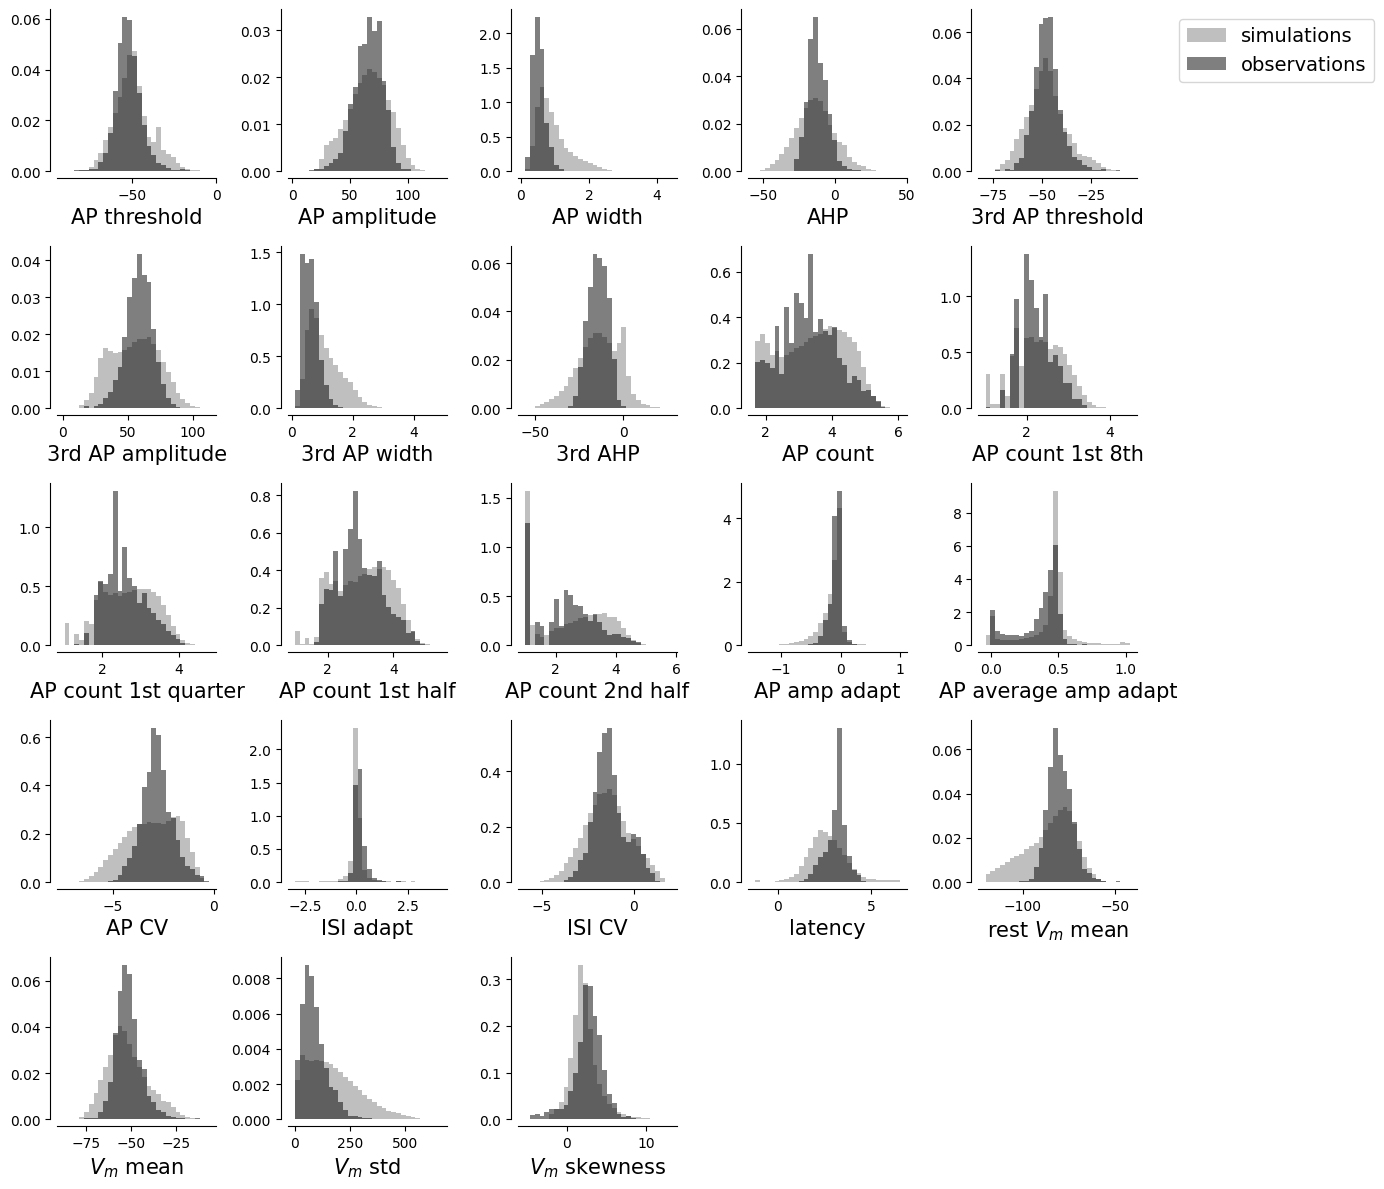

In [101]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        adjust_spines(ax,['bottom', 'left'])
for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

#### Training schedule 2b: noise with 0.01 amplitude added to ephys features of unique best Euclidean prior simulations

In [102]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=0.01 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
stats_tr += noise_stats

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['2b'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


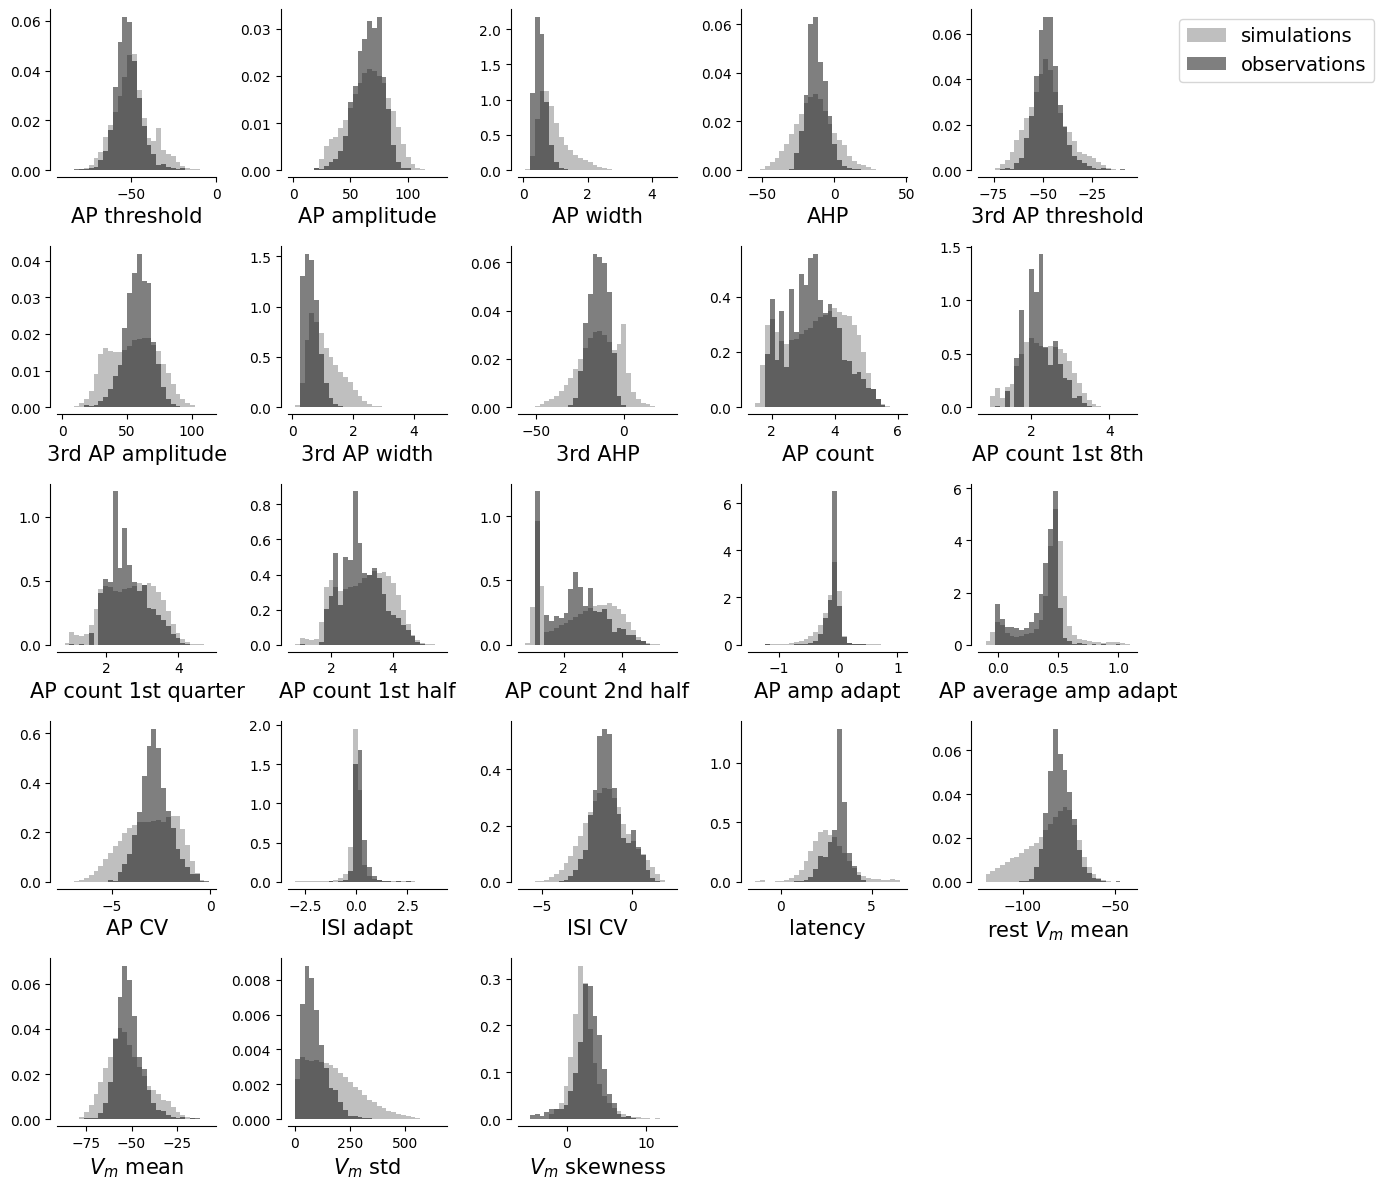

In [103]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        adjust_spines(ax,['bottom', 'left'])
for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

#### Training schedule 2c: noise with 0.05 amplitude added to ephys features of unique best Euclidean prior simulations

In [104]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=0.05 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
stats_tr += noise_stats

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['2c'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


#### Training schedule 2d: noise with 0.1 amplitude added to ephys features of unique best Euclidean prior simulations

This is the training schedule that leads to NPE-N, that is running NPE with an adequate amount of Gaussian isotropic noise intoduced to the summarizing statistics of simulations.

In [105]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=0.1 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
stats_tr += noise_stats

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['2d'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


#### Training schedule 2e: noise with 1 amplitude added to ephys features of unique best Euclidean prior simulations

In [106]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=1 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
stats_tr += noise_stats

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['2e'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


#### Training schedule 3: noise with 0.05 amplitude added to ephys features *and* model parameters of unique best Euclidean prior simulations

In [107]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]
eps=0.05 # noise amplitude
noise_stats=np.random.multivariate_normal(
    np.zeros((stats_tr.shape[1])),
    eps*np.diag(stats_tr.std(axis=0)),
    size=stats_tr.shape[0]
)
noise_params=np.random.multivariate_normal(
    np.zeros((theta_tr.shape[1])),
    eps*np.diag(theta_tr.std(axis=0)),
    size=theta_tr.shape[0]
)
stats_tr += noise_stats
theta_tr += noise_params

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['3'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (55677, 14)
(# sims, # ephys features):  (55677, 23)


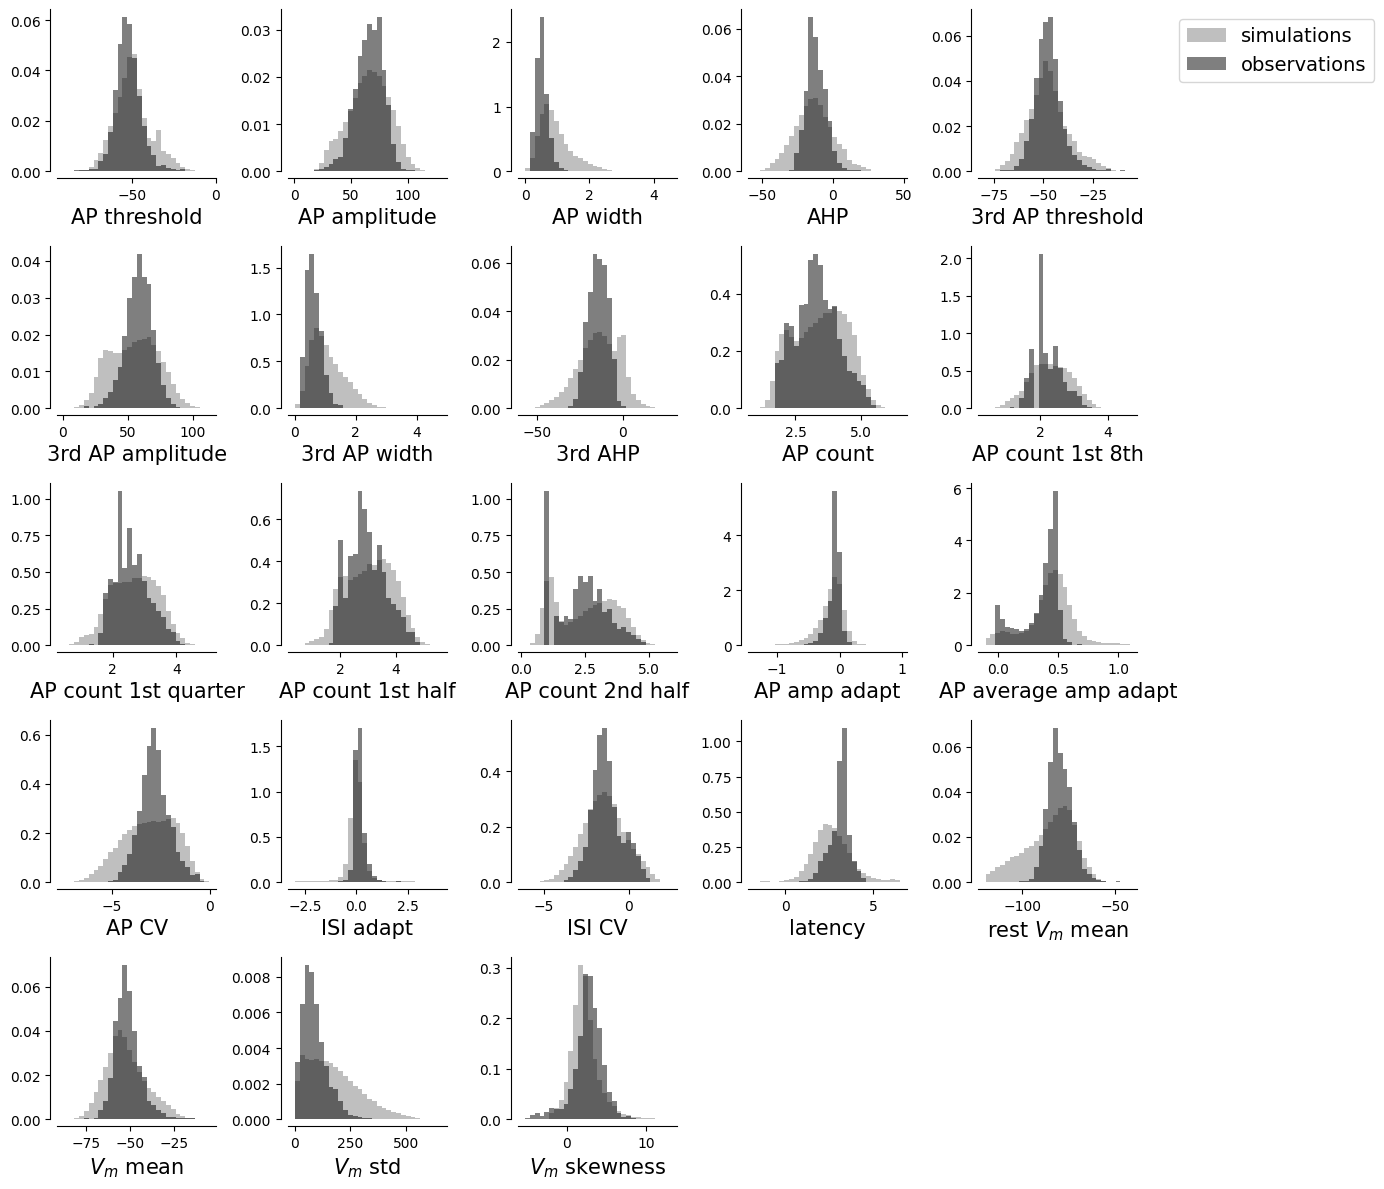

In [108]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        adjust_spines(ax,['bottom', 'left'])
for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

#### Training schedule 4: noise with 0.05 amplitude added to ephys features of less best Euclidean prior simulations + original less best unique Euclidean prior simulations themselves

We would like to approximately have a same number of training examples for SBI across training schedules, so that the difference in performance cannot be due to significant different training set sizes, but due to our different training schedules used. To this end, we will start from a reduced batch of best Euclidean prior simulations per experimental observation and then do data augmentation.

In [109]:
theta_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['theta']
stats_tr = np.load('./save_sims/best_{}_Euclidean_sims_{}.npz'.format(N_closest, ds))['stats']
theta_tr=np.reshape(theta_tr, (N_closest, D.shape[0], len(model_param_names)))
stats_tr=np.reshape(stats_tr, (N_closest, D.shape[0], feature_list[-1]+1))
N_closest_new=69
theta_tr=theta_tr[:N_closest_new,:,:]
stats_tr=stats_tr[:N_closest_new,:,:]
theta_tr=np.reshape(theta_tr, (N_closest_new*D.shape[0], len(model_param_names)))
stats_tr=np.reshape(stats_tr, (N_closest_new*D.shape[0], feature_list[-1]+1))
eps=0.05 # noise amplitude
noise_stats=np.random.multivariate_normal(np.zeros((stats_tr.shape[1])),
                                    eps*np.diag(stats_tr.std(axis=0)),
                                    size=2*stats_tr.shape[0])
theta_tr=np.concatenate(
    (theta_tr,
     theta_tr,
     theta_tr
    ),
    axis=0
)

stats_tr=np.concatenate(
    (stats_tr,
     stats_tr+noise_stats[:stats_tr.shape[0],:],
     stats_tr+noise_stats[stats_tr.shape[0]:2*stats_tr.shape[0],:]
    ),
    axis=0
)

_, unique_tr_ids=np.unique(np.sum(stats_tr, axis=1),return_index=True)
theta_tr=theta_tr[unique_tr_ids,:]
stats_tr=stats_tr[unique_tr_ids,:]

print('(# sims, # model parameters): ', theta_tr.shape)
print('(# sims, # ephys features): ', stats_tr.shape)

training_schedules['4'].update({'theta':theta_tr, 'stats':stats_tr})

(# sims, # model parameters):  (345270, 14)
(# sims, # ephys features):  (345270, 23)


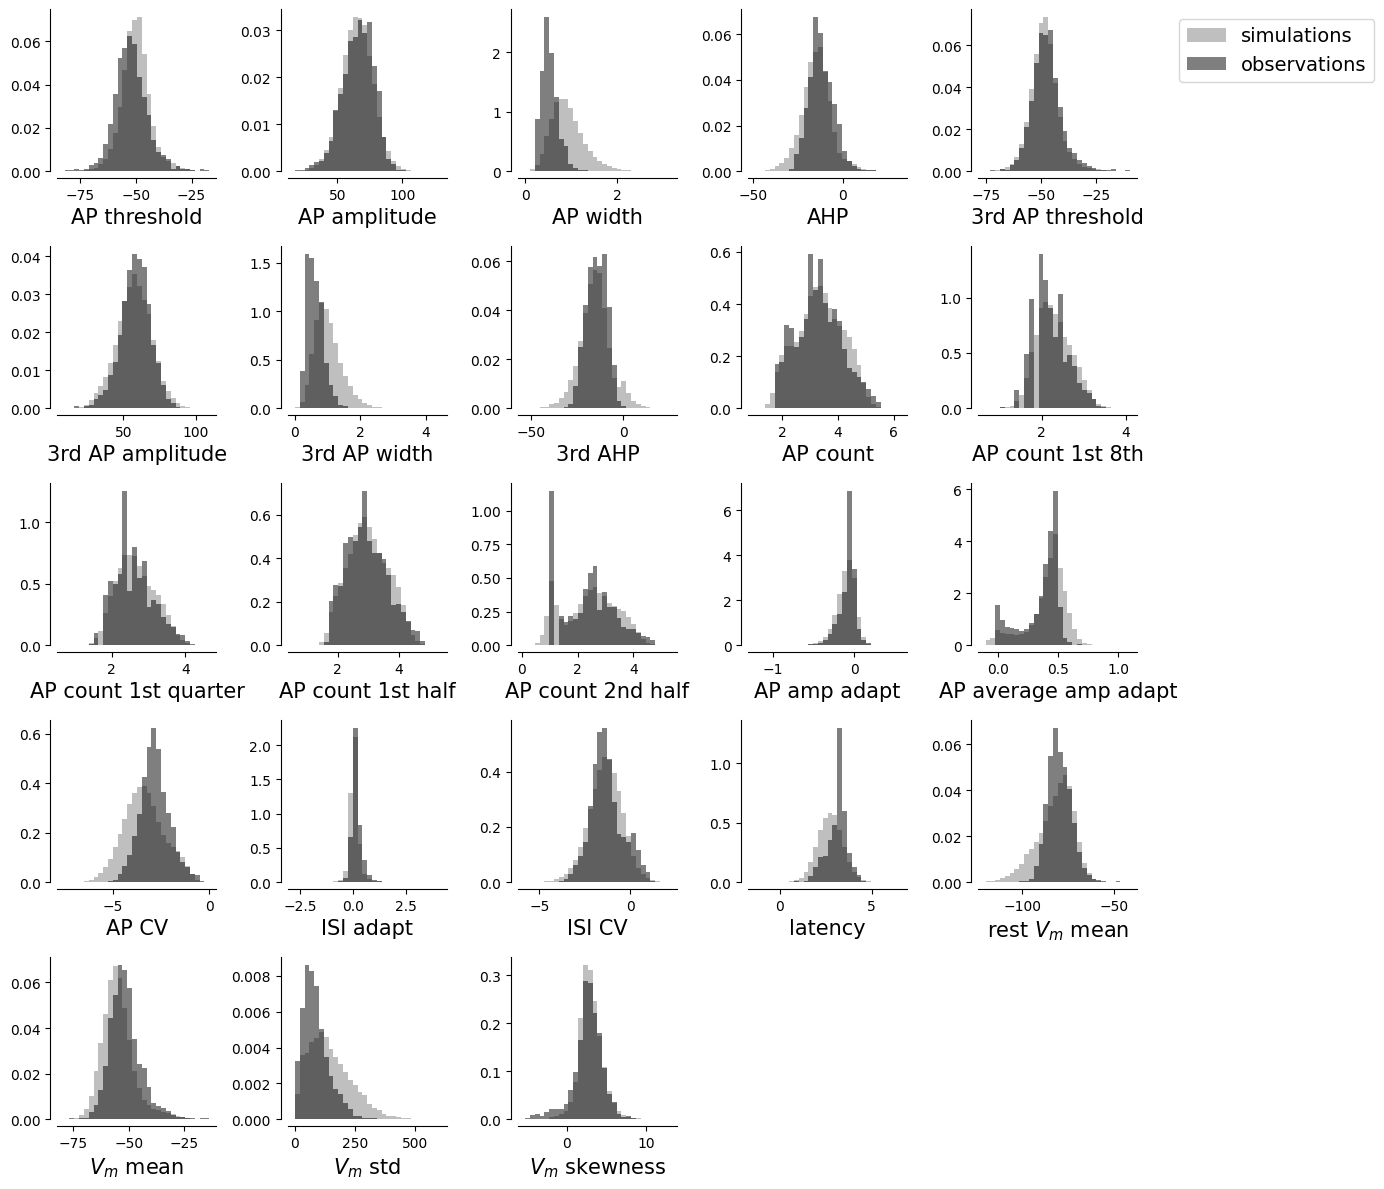

In [110]:
fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[feature_list]):
        ax.hist([D[ephys_features[i]].values,
                 stats_tr[:,i][(stats_tr[:,i]>limits[ephys_features[i]][0])&\
                               (stats_tr[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))
        adjust_spines(ax,['bottom', 'left'])
for ax in axes.reshape(-1)[feature_list[-1]+1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

## Building amortized posteriors

In [113]:
inference

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=14, out_features=50, bias=True)
            (context_layer): Linear(in_features=23, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=28, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=14, out_features=50, bias=True)
            (context_layer): Linear(in_fea

In [112]:
density_estimator

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=14, out_features=50, bias=True)
            (context_layer): Linear(in_features=23, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=28, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=14, out_features=50, bias=True)
            (context_layer): Linear(in_fea

In [ ]:
posterior = inference.build_posterior(density_estimator)

In [114]:
print('Building amortized posterior with training schedules: ')

t = time.time()

for tr_schedule in training_schedules:
    print('\n', tr_schedule)
    inference = NPE(
        prior, 
        density_estimator=build_maf
    )
    inference = inference.append_simulations(
                 torch.as_tensor(training_schedules[tr_schedule]['theta'], dtype=torch.float32),
                 torch.as_tensor(training_schedules[tr_schedule]['stats'], dtype=torch.float32)
                )
    density_estimator = inference.train()
    posterior = inference.build_posterior(density_estimator)

    with open('save_posteriors/{}/training_schedule_{}.pickle'.format(ds,tr_schedule), 'wb') as f:
        pickle.dump(posterior, f)
    
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('\nTime: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Building amortized posterior with training schedules: 

 0
 Neural network successfully converged after 477 epochs.
 1
 Neural network successfully converged after 383 epochs.
 2a
 Neural network successfully converged after 322 epochs.
 2b
 Neural network successfully converged after 340 epochs.
 2c
 Neural network successfully converged after 374 epochs.
 2d
 Neural network successfully converged after 289 epochs.
 2e
 Neural network successfully converged after 347 epochs.
 3
 Neural network successfully converged after 487 epochs.
 4
 Neural network successfully converged after 320 epochs.
Time: 1.0h 31m 59s


#### Save 10 random posterior samples and the highest posterior sample for each observed experimental cell for each amortized posterior.

For some experiments, depending on the training schedule, its summary statistics could be so different from simulations, the posterior finds barely any support from the prior. Sampling will therefore take prohibitively long. We therefore check and put them in the 'fails' dictionary. In case you've run new posteriors, you'll have to run the 2nd next block and see for which cell id's it takes too long. Then you can put them in `fails` below.

In [ ]:
# Scala:
fails={
    '4':[856],
    '3':[],
    '2e':[],
    '2d':[],
    '2c':[],
    '2b':[],
    '2a':[951],
    '1':[238,641,856],
    '0':[1,381,446,681,723,910]
}
# Gouwens:
fails_g={
    '4':[],
    '3':[],
    '2e':[],
    '2d':[],
    '2c':[],
    '2b':[],
    '2a':[],
    '1':[],
    '0':[]
}

In [ ]:
print('Extracting the highest posterior sample and 10 random posterior samples', 
      'for each experimentally observed cell and for each training schedule: ')
index=0
for tr_schedule in ['4','3','2d','2c','2b','2a','1','0']:
    print('\n', 'Training schedule: ', tr_schedule)
    
    THETA={'highest posterior samples':{}, '10 random samples':{}}
    
    with open('save_posteriors/{}/training_schedule_{}.pickle'.format(ds,tr_schedule), 'rb') as f:
        posterior=pickle.load(f)
        
    for i in range(index, D.shape[0]):
        if i in fails[tr_schedule]:
            continue
        else:
            xo=D.iloc[i,:].values
            cell_name=D.index[i]
            print(str(i) + ' ', end='')

            # sampling 10000 from the posterior
            samples=posterior.sample(
                (10000,),
                x=torch.as_tensor(xo[feature_list], dtype=float),
                show_progress_bars=False
            )

            # highest posterior simulation
            highest_post_sample_1=samples[np.argsort(np.array(posterior.log_prob(theta=samples, x=xo[feature_list])))[-1],:]

            THETA['highest posterior samples'].update({cell_name:np.array(highest_post_sample_1)})
            THETA['10 random samples'].update({cell_name:samples[torch.randint(10000, (10,)),:]})
        
    with open('save_model_parameters/{}/training_schedule_{}.pickle'.format(ds,tr_schedule), 'wb') as f:
        pickle.dump(THETA, f)